 ## Načtení API množství dat z antény internetu Palackého 209

In [1]:
import requests
import urllib3
from requests.auth import HTTPBasicAuth
import json

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

url = "https://192.168.11.100:34443/rest/interface"
user = "api"
password = "counters"

resp = requests.get(url, auth=HTTPBasicAuth(user, password), verify=False)
data = resp.json()

print(json.dumps(data, indent=2))  # ukáže celou strukturu


/Users/Marek/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[
  {
    ".id": "*12",
    "actual-mtu": "1500",
    "default-name": "ether1",
    "disabled": "false",
    "fp-rx-byte": "1771610896",
    "fp-rx-packet": "8088048",
    "fp-tx-byte": "17898812829",
    "fp-tx-packet": "15942088",
    "l2mtu": "1598",
    "last-link-down-time": "2025-09-20 10:43:08",
    "last-link-up-time": "2025-09-20 10:43:09",
    "link-downs": "3",
    "mac-address": "D4:CA:6D:9E:F8:A0",
    "max-l2mtu": "2028",
    "mtu": "1500",
    "name": "ether1",
    "running": "true",
    "rx-byte": "1771610896",
    "rx-drop": "0",
    "rx-error": "0",
    "rx-packet": "8088048",
    "tx-byte": "18133286027",
    "tx-drop": "0",
    "tx-error": "0",
    "tx-packet": "16717970",
    "tx-queue-drop": "0",
    "type": "ether"
  },
  {
    ".id": "*16",
    "actual-mtu": "1500",
    "default-name": "wlan1",
    "disabled": "false",
    "fp-rx-byte": "18240670365",
    "fp-rx-packet": "17651355",
    "fp-tx-byte": "1551623587",
    "fp-tx-packet": "7194802",
    "l2mtu": "160

## Načtení a úprava API množství dat z antény internetu Palackého 209

In [1]:
#!/usr/bin/env python3
"""
save_iface_stats_mikrotik.py
Stáhne rozhraní z REST endpointu s HTTP Basic Auth, najde MAC D4:CA:6D:9E:F8:A0 a uloží rx/tx bytes.
Podporuje self-signed certifikát.
"""

import requests
import urllib3
import csv
import sqlite3
from datetime import datetime
from requests.auth import HTTPBasicAuth

TARGET_MAC = "D4:CA:6D:9E:F8:A0"

# všechny relevantní klíče pro RX/TX
RX_KEYS = {"rx-byte", "fp-rx-byte", "rxBytes", "rx_bytes"}
TX_KEYS = {"tx-byte", "fp-tx-byte", "txBytes", "tx_bytes"}

MAC_KEYS = {"mac-address", "macAddress", "mac", "hwaddr"}

def norm_mac(mac: str) -> str:
    s = mac.strip().upper().replace("-", ":").replace(".", "").replace(" ", "")
    if ":" not in s and len(s) == 12:
        s = ":".join(s[i:i+2] for i in range(0, 12, 2))
    return s

def find_mac_record(data, target_mac):
    target = norm_mac(target_mac)
    for item in data:  # data je seznam dictů
        for mk in MAC_KEYS:
            if mk in item and norm_mac(str(item[mk])) == target:
                return item
    return None

def extract_rx_tx(record):
    rx = tx = 0
    for k in RX_KEYS:
        if k in record:
            rx = int(record[k])
            break
    for k in TX_KEYS:
        if k in record:
            tx = int(record[k])
            break
    return rx, tx

def save_to_csv(path, row):
    import os
    header = ["timestamp", "mac", "rx_bytes", "tx_bytes"]
    exists = os.path.exists(path)
    with open(path, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=header)
        if not exists:
            writer.writeheader()
        writer.writerow(row)

def save_to_sqlite(db_path, row):
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute("""
        CREATE TABLE IF NOT EXISTS iface_stats (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp TEXT,
            mac TEXT,
            rx_bytes INTEGER,
            tx_bytes INTEGER
        )
    """)
    cur.execute("INSERT INTO iface_stats (timestamp, mac, rx_bytes, tx_bytes) VALUES (?, ?, ?, ?)",
                (row["timestamp"], row["mac"], row["rx_bytes"], row["tx_bytes"]))
    conn.commit()
    conn.close()

def run(url, user, password, mac=TARGET_MAC, csv_path="iface_stats.csv", sqlite_path="iface_stats.db", insecure=True):
    if insecure:
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    resp = requests.get(url, auth=HTTPBasicAuth(user, password), verify=not insecure)
    resp.raise_for_status()
    data = resp.json()
    rec = find_mac_record(data, mac)
    if not rec:
        raise ValueError(f"MAC {mac} nebyla nalezena v datech")
    rx, tx = extract_rx_tx(rec)
    ts = datetime.utcnow().isoformat(timespec="seconds") + "Z"
    row = {"timestamp": ts, "mac": norm_mac(mac), "rx_bytes": rx, "tx_bytes": tx}
    save_to_csv(csv_path, row)
    save_to_sqlite(sqlite_path, row)
    print(f"Uloženo: {row}")

# ----------------------
# Příklad volání
# ----------------------
if __name__ == "__main__":
    run(
        url="https://192.168.11.100:34443/rest/interface",
        user="api",
        password="counters"
    )


/Users/Marek/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Uloženo: {'timestamp': '2025-09-25T20:23:56Z', 'mac': 'D4:CA:6D:9E:F8:A0', 'rx_bytes': 7285026952, 'tx_bytes': 45661862260}


In [2]:
# rm iface_stats.db


# Úprava exportovaného CSV na soubor rozdily_counter.CSV

In [3]:
import csv

BYTES_IN_MB = 1048576  # 1 MB = 1024*1024 B

input_file = "iface_stats.csv"
output_file = "rozdily_counter.csv"

with open(input_file, newline="", encoding="utf-8") as f_in, \
     open(output_file, "w", newline="", encoding="utf-8") as f_out:

    reader = csv.DictReader(f_in)
    fieldnames = ["timestamp", "mac", "rx_MB", "tx_MB", "delta_rx_MB", "delta_tx_MB"]
    writer = csv.DictWriter(f_out, fieldnames=fieldnames)
    writer.writeheader()

    prev_rx = prev_tx = 0
    for row in reader:
        # převod bytes na MB
        rx_bytes = float(row.get("rx_bytes", 0) or 0)
        tx_bytes = float(row.get("tx_bytes", 0) or 0)
        rx_MB = rx_bytes / BYTES_IN_MB
        tx_MB = tx_bytes / BYTES_IN_MB

        # výpočet delta oproti předchozímu řádku
        delta_rx = rx_MB - prev_rx
        delta_tx = tx_MB - prev_tx

        writer.writerow({
            "timestamp": row.get("timestamp", ""),
            "mac": row.get("mac", ""),
            "rx_MB": round(rx_MB, 2),
            "tx_MB": round(tx_MB, 2),
            "delta_rx_MB": round(delta_rx, 2),
            "delta_tx_MB": round(delta_tx, 2)
        })

        # uložit aktuální hodnoty pro delta v dalším řádku
        prev_rx = rx_MB
        prev_tx = tx_MB

print(f"Hotovo! Výsledek uložen do {output_file}")


Hotovo! Výsledek uložen do rozdily_counter.csv


In [4]:
import pandas as pd

BYTES_IN_MB = 1048576

df_counter = pd.read_csv("iface_stats.csv")
df_counter["rx_MB"] = df_counter["rx_bytes"].fillna(0).astype(float) / BYTES_IN_MB
df_counter["tx_MB"] = df_counter["tx_bytes"].fillna(0).astype(float) / BYTES_IN_MB
df_counter["delta_rx_MB"] = df_counter["rx_MB"].diff().fillna(0)
df_counter["delta_tx_MB"] = df_counter["tx_MB"].diff().fillna(0)

# df_counter.to_csv("rozdily_counter.csv", index=False, columns=["timestamp", "mac", "rx_MB", "tx_MB", "delta_rx_MB", "delta_tx_MB"])


In [5]:
df_counter

,timestamp,mac,rx_bytes,tx_bytes,rx_MB,tx_MB,delta_rx_MB,delta_tx_MB
0,2025-09-20T09:58:17Z,D4:CA:6D:9E:F8:A0,992096299,7928321072,946.136760,7561.036179,0.000000,0.000000
1,2025-09-20T20:29:54Z,D4:CA:6D:9E:F8:A0,1606070689,16625926158,1531.668366,15855.718763,585.531607,8294.682585
2,2025-09-21T06:59:19Z,D4:CA:6D:9E:F8:A0,1771610896,17898812829,1689.539810,17069.638089,157.871444,1213.919326
3,2025-09-21T15:00:23Z,D4:CA:6D:9E:F8:A0,2718819388,23074502344,2592.868221,22005.560249,903.328411,4935.922160
4,2025-09-21T19:21:05Z,D4:CA:6D:9E:F8:A0,2818347700,23681014503,2687.785816,22583.975318,94.917595,578.415069
5,2025-09-21T22:11:21Z,D4:CA:6D:9E:F8:A0,2895603927,24327557977,2761.463096,23200.567224,73.677279,616.591906
6,2025-09-22T06:29:40Z,D4:CA:6D:9E:F8:A0,2942804441,24430230624,2806.477014,23298.483490,45.013918,97.916266
7,2025-09-22T09:56:27Z,D4:CA:6D:9E:F8:A0,2953081918,24467445398,2816.278379,23333.974264,9.801366,35.490774
8,2025-09-22T13:28:37Z,D4:CA:6D:9E:F8:A0,2994850108,24512236306,2856.111629,23376.690203,39.833250,42.715939
9,2025-09-22T17:29:25Z,D4:CA:6D:9E:F8:A0,3033772384,24701799977,2893.230804,23557.472207,37.119175,180.782004


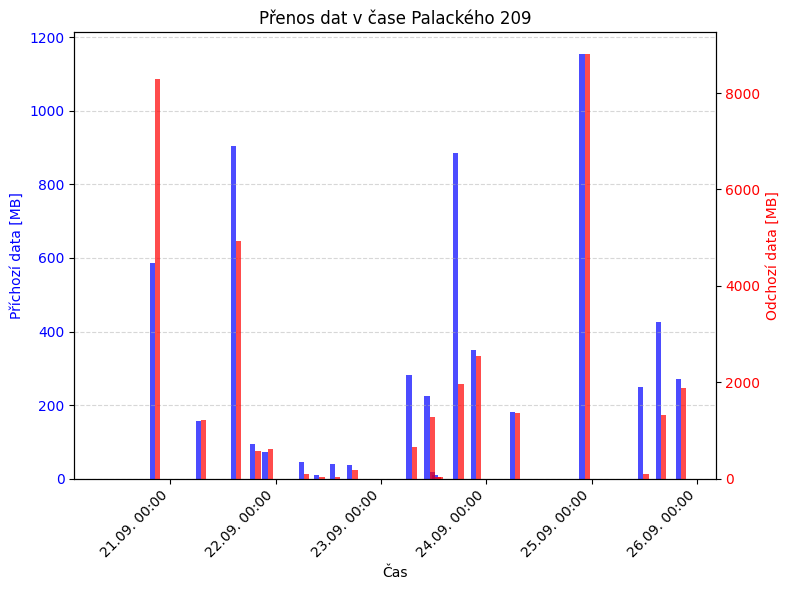

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Převod timestamp na datetime
df_counter["timestamp"] = pd.to_datetime(df_counter["timestamp"])

# Vytvoření figure a hlavní osy
fig, ax1 = plt.subplots(figsize=(8, 6))

# Šířka jednoho sloupce (v jednotkách dnů)
bar_width = 0.05

# Převod timestamp na číselnou osu (matplotlib)
x = mdates.date2num(df_counter["timestamp"])

# RX – levá osa
ax1.bar(
    x - bar_width/2,
    df_counter["delta_rx_MB"],
    width=bar_width,
    label="Příchozí data (RX)",
    color="blue",
    alpha=0.7
)
ax1.set_xlabel("Čas")
ax1.set_ylabel("Příchozí data [MB]", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")


# TX – pravá osa
ax2 = ax1.twinx()
ax2.bar(
    x + bar_width/2,
    df_counter["delta_tx_MB"],
    width=bar_width,
    label="Odchozí data (TX)",
    color="red",
    alpha=0.7
)
ax2.set_ylabel("Odchozí data [MB]", color="red")
ax2.tick_params(axis="y", labelcolor="red")


# Formátování osy X
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m. %H:%M"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# Titulek a legenda
plt.title("Přenos dat v čase Palackého 209")

# Mřížka pro hlavní osu
ax1.grid(True, axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
fig.savefig("prenos_dat.png", dpi=300)  # dpi=300 pro vysokou kvalitu
plt.show()


In [7]:
import pandas as pd

df_filtered2 = df_counter.tail(2)[['timestamp', 'delta_rx_MB', 'delta_tx_MB']]
df_filtered2['timestamp_plus_2h'] = df_filtered2['timestamp'] + pd.Timedelta(hours=2)
df_filtered2['timestamp_plus_2h_fmt'] = df_filtered2['timestamp_plus_2h'].dt.strftime('%d.%m.%y %H:%M')
# df_filtered = df_counter[(df_counter['delta_tx_MB'] > 1000)]
# df_filtered2 = df_counter.iloc[12:][['timestamp', 'delta_rx_MB', 'delta_tx_MB']]
print(df_filtered2[['timestamp_plus_2h_fmt', 'delta_rx_MB', 'delta_tx_MB']])
# df_filtered2.to_csv("17-18_9_counter.csv", index=False, columns=["timestamp", "mac", "rx_MB", "tx_MB", "delta_rx_MB", "delta_tx_MB"])

   timestamp_plus_2h_fmt  delta_rx_MB  delta_tx_MB
19        25.09.25 17:47   427.119418  1328.693164
20        25.09.25 22:23   270.470776  1879.058303


In [8]:
x1=x+0.08333333333333333
x1

array([20351.49880787, 20351.93743056, 20352.37452546, 20352.70859954,
       20352.8896412 , 20353.00788194, 20353.35393519, 20353.49753472,
       20353.64487269, 20353.81209491, 20354.37450231, 20354.54502315,
       20354.59864583, 20354.62099537, 20354.81877315, 20354.98576389,
       20355.35552083, 20356.01666667, 20356.57331019, 20356.74097222,
       20356.93328704])

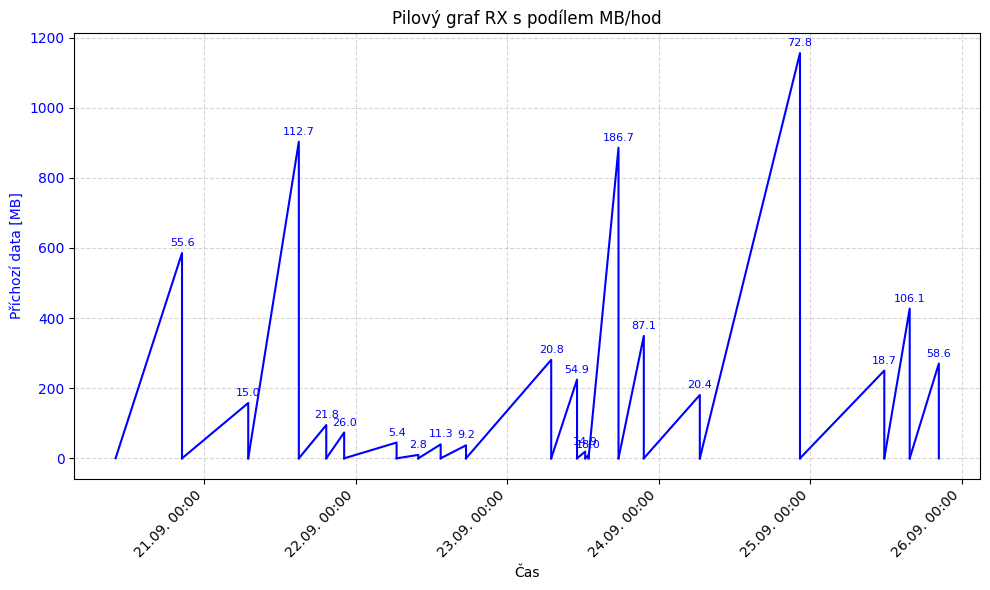

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_counter["timestamp"] = pd.to_datetime(df_counter["timestamp"])

fig, ax1 = plt.subplots(figsize=(10, 6))

for i in range(1, len(df_counter)):
    t_prev = df_counter["timestamp"].iloc[i - 1]
    t_curr = df_counter["timestamp"].iloc[i]
    rx = df_counter["delta_rx_MB"].iloc[i]

    # Pilový zub: náběh z nuly, pád zpět
    rx_timestamps = [t_prev, t_curr, t_curr]
    rx_values = [0, rx, 0]
    ax1.plot(rx_timestamps, rx_values, color="blue", linewidth=1.5)

    # Výpočet podílu MB/hod
    delta_hours = (t_curr - t_prev).total_seconds() / 3600
    if delta_hours > 0:
        rate_MBph = rx / delta_hours
        label = f"{rate_MBph:.1f}"  # bez jednotky, jedno desetinné místo

        # Anotace nad vrcholem zubu
        ax1.annotate(
            label,
            xy=(t_curr, rx),
            xytext=(0, 5),
            textcoords="offset points",
            ha="center",
            fontsize=8,
            color="blue"
        )

# Osa X a Y
ax1.set_xlabel("Čas")
ax1.set_ylabel("Příchozí data [MB]", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m. %H:%M"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")
ax1.grid(True, linestyle="--", alpha=0.5)

plt.title("Pilový graf RX s podílem MB/hod")
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd

# Převod timestamp na datetime
df_counter["timestamp"] = pd.to_datetime(df_counter["timestamp"])

# Vytvoření tabulky s výpočtem podílu
rows = []

for i in range(1, len(df_counter)):
    t_prev = df_counter["timestamp"].iloc[i - 1]
    t_curr = df_counter["timestamp"].iloc[i]
    rx = df_counter["delta_rx_MB"].iloc[i]

    delta_hours = (t_curr - t_prev).total_seconds() / 3600
    mb_per_hour = rx / delta_hours if delta_hours > 0 else None

    rows.append({
    "start_time": t_prev.strftime("%d.%m.%y %H:%M"),
    "end_time": t_curr.strftime("%d.%m.%y %H:%M"),
    "delta_rx_MB": rx,
    "delta_hours": round(delta_hours, 2),
    "MB_per_hour": round(mb_per_hour, 1)
})


df_rx_table = pd.DataFrame(rows)
print(df_rx_table)


        start_time        end_time  delta_rx_MB  delta_hours  MB_per_hour
0   20.09.25 09:58  20.09.25 20:29   585.531607        10.53         55.6
1   20.09.25 20:29  21.09.25 06:59   157.871444        10.49         15.0
2   21.09.25 06:59  21.09.25 15:00   903.328411         8.02        112.7
3   21.09.25 15:00  21.09.25 19:21    94.917595         4.34         21.8
4   21.09.25 19:21  21.09.25 22:11    73.677279         2.84         26.0
5   21.09.25 22:11  22.09.25 06:29    45.013918         8.31          5.4
6   22.09.25 06:29  22.09.25 09:56     9.801366         3.45          2.8
7   22.09.25 09:56  22.09.25 13:28    39.833250         3.54         11.3
8   22.09.25 13:28  22.09.25 17:29    37.119175         4.01          9.2
9   22.09.25 17:29  23.09.25 06:59   280.941169        13.50         20.8
10  23.09.25 06:59  23.09.25 11:04   224.543580         4.09         54.9
11  23.09.25 11:04  23.09.25 12:22    19.213716         1.29         14.9
12  23.09.25 12:22  23.09.25 12:54    